['/home/komal.kumar/Documents/Cell/datasets/celltrack/2D/Fluo-N2DL-HeLa/train/Fluo-N2DL-HeLa/01/t000.tif', '/home/komal.kumar/Documents/Cell/datasets/celltrack/2D/Fluo-N2DL-HeLa/train/Fluo-N2DL-HeLa/01/t001.tif', '/home/komal.kumar/Documents/Cell/datasets/celltrack/2D/Fluo-N2DL-HeLa/train/Fluo-N2DL-HeLa/01/t002.tif', '/home/komal.kumar/Documents/Cell/datasets/celltrack/2D/Fluo-N2DL-HeLa/train/Fluo-N2DL-HeLa/01/t003.tif', '/home/komal.kumar/Documents/Cell/datasets/celltrack/2D/Fluo-N2DL-HeLa/train/Fluo-N2DL-HeLa/01/t004.tif', '/home/komal.kumar/Documents/Cell/datasets/celltrack/2D/Fluo-N2DL-HeLa/train/Fluo-N2DL-HeLa/01/t005.tif', '/home/komal.kumar/Documents/Cell/datasets/celltrack/2D/Fluo-N2DL-HeLa/train/Fluo-N2DL-HeLa/01/t006.tif', '/home/komal.kumar/Documents/Cell/datasets/celltrack/2D/Fluo-N2DL-HeLa/train/Fluo-N2DL-HeLa/01/t007.tif', '/home/komal.kumar/Documents/Cell/datasets/celltrack/2D/Fluo-N2DL-HeLa/train/Fluo-N2DL-HeLa/01/t008.tif', '/home/komal.kumar/Documents/Cell/datasets/ce

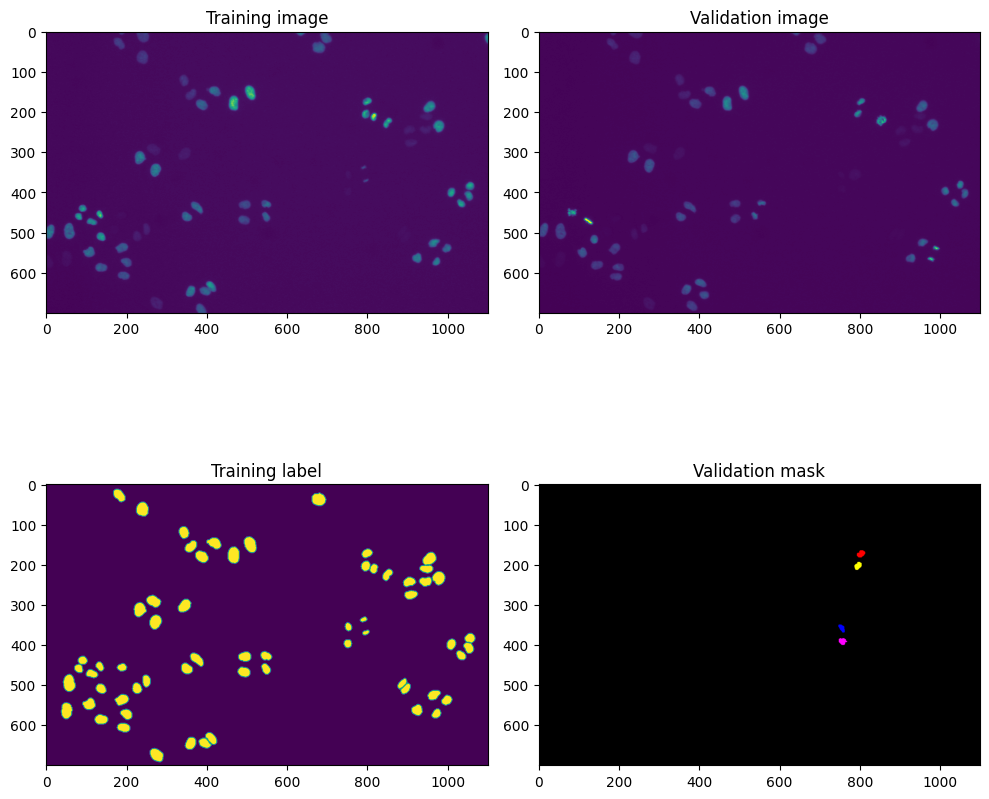

In [12]:
'''
Author:
Tianqi Guo 
Yin Wang
EISL-A @ Purdue University - School of Electrical and Computer Engineering
Do not use for commercial purposes. All rights reserved.
Contact:
guo246@purdue.edu
'''

import os
import glob
import random
import shutil

import imageio
import numpy as np
from scipy import ndimage
import skimage.color as clr
import matplotlib.pyplot as plt

def seg_to_lbl(seg, itr_dilation, itr_erosion):
    s1, s2 = seg.shape
    cell_set = np.delete(np.unique(seg), 0) 
    background = (seg == 0)
    lbl = np.zeros_like(seg, dtype=np.uint8)
    
    for cell in cell_set:    
        mask_original = (seg == cell)
        mask_dilated = ndimage.binary_dilation(mask_original, iterations=itr_dilation)
        mask_dilated = np.logical_and(mask_dilated, background)
        lbl[mask_dilated] = 1
        lbl[mask_original] = 2 
        
        mask_eroded = ndimage.binary_erosion(mask_original, iterations=itr_erosion)
        mask_boundary = np.logical_and(mask_original, np.logical_not(mask_eroded))
        ys, xs = np.nonzero(mask_boundary)
        
        for y, x in zip(ys, xs):
            for dy in range(-itr_erosion, itr_erosion + 1):
                for dx in range(-itr_erosion, itr_erosion + 1):
                    yy, xx = y + dy, x + dx                
                    if 0 <= yy < s1 and 0 <= xx < s2:
                        if seg[yy, xx] > 0 and seg[yy, xx] != cell:
                            lbl[y, x] = 1
                            break
    return lbl

def process_set(case, data_set, itr_dilation, itr_erosion, set_='train'):
    ppth = f"/home/komal.kumar/Documents/Cell/datasets/celltrack/2D/Fluo-N2DL-HeLa/{set_}/{case}"
    img_list = sorted(glob.glob(os.path.join(ppth, data_set, "*.tif")))
    print(img_list)
    
    intensity_min, intensity_max = np.inf, 0
    
    for image_path in img_list:
        img = np.asarray(imageio.volread(image_path), dtype=np.double)        
        intensity_min = np.minimum(intensity_min, img.min())
        intensity_max = np.maximum(intensity_max, img.max())
    
    intensity_range = intensity_max - intensity_min
    print(intensity_min, intensity_max, intensity_range)
    
    N_valid = len(glob.glob(os.path.join(valid_IM_dir, '*.npy')))
    N_train = len(glob.glob(os.path.join(train_IM_dir, '*.npy')))
    
    images_validation_list = []
    
    for idx, image_path in enumerate(sorted(glob.glob(os.path.join(ppth, f"{data_set}_GT", "SEG", "*.tif")))):
        file_name = os.path.basename(image_path)
        f = int(''.join([c for c in file_name if c.isdigit()]))           
        images_validation_list.append(f) 
        
        img = np.asarray(imageio.volread(img_list[f]), dtype=np.single)[None, :, :]       
        img = (img - intensity_min) / intensity_range
        
        seg = np.asarray(imageio.volread(image_path), dtype=np.uint16)           
        lbl = seg_to_lbl(seg, itr_dilation, itr_erosion)
        
        data = np.array([img, lbl], dtype=object)        
        np.save(os.path.join(valid_IM_dir, '%0.4d.npy' % N_valid), data)
        imageio.imwrite(os.path.join(valid_GT_dir, 'man_seg%0.3d.tif' % N_valid), seg)
        imageio.imwrite(os.path.join(valid_RS_dir, 'mask%0.3d.tif' % N_valid), seg)
        N_valid += 1
        
    for idx, image_path in enumerate(sorted(glob.glob(os.path.join(ppth, f"{data_set}_ST", "SEG", "*.tif")))):
        file_name = os.path.basename(image_path)
        f = int(''.join([c for c in file_name if c.isdigit()]))   
        if f in images_validation_list: continue
        
        img = np.asarray(imageio.volread(img_list[f]), dtype=np.single)[None, :, :]       
        img = (img - intensity_min) / intensity_range
        
        seg = np.asarray(imageio.volread(image_path), dtype=np.uint16)                          
        lbl = seg_to_lbl(seg, itr_dilation, itr_erosion)
        
        data = np.array([img, lbl], dtype=object)        
        np.save(os.path.join(train_IM_dir, '%0.4d.npy' % N_train), data)
        imageio.imwrite(os.path.join(train_GT_dir, 'man_seg%0.3d.tif' % N_train), seg)
        imageio.imwrite(os.path.join(train_RS_dir, 'mask%0.3d.tif' % N_train), seg)
        N_train += 1
        
    return

case = 'Fluo-N2DL-HeLa' 
itr_dilation = 2
itr_erosion = 2

out_dir = os.path.join('/home/komal.kumar/Documents/Cell/datasets/pre/GT+ST', case)
if os.path.exists(out_dir):  
    shutil.rmtree(out_dir)
    
train_IM_dir = os.path.join(out_dir, '01')
train_GT_dir = os.path.join(out_dir, '01_GT', 'SEG')
train_RS_dir = os.path.join(out_dir, '01_RES')

valid_IM_dir = os.path.join(out_dir, '02')
valid_GT_dir = os.path.join(out_dir, '02_GT', 'SEG')
valid_RS_dir = os.path.join(out_dir, '02_RES')

os.makedirs(train_IM_dir)
os.makedirs(train_GT_dir)
os.makedirs(train_RS_dir)
os.makedirs(valid_IM_dir)
os.makedirs(valid_GT_dir)
os.makedirs(valid_RS_dir)

process_set(case, '01', itr_dilation, itr_erosion)
process_set(case, '02', itr_dilation, itr_erosion)

N_training = len(glob.glob(os.path.join(train_IM_dir, '*.npy')))

idx = random.randint(0, N_training-1)
img_training, lbl_training = np.load(os.path.join(train_IM_dir, '%0.4d.npy' % idx), allow_pickle=True)

print('Training set:')
print('# of training pairs:', N_training, 'range:', img_training.min(), img_training.max())
print('# of SEGs:', len(glob.glob(os.path.join(train_GT_dir, '*.tif'))), len(glob.glob(os.path.join(train_RS_dir, '*.tif'))))
print('eg # %d' % idx)

N_validation = len(glob.glob(os.path.join(valid_IM_dir, '*.npy')))
idx = random.randint(0, N_validation-1)
img_validation, lbl_validation = np.load(os.path.join(valid_IM_dir, '%0.4d.npy' % idx), allow_pickle=True)

print('Validation set:')
print('# of validation pairs:', N_validation, 'range:', img_validation.min(), img_validation.max())
print('# of SEGs:', len(glob.glob(os.path.join(valid_GT_dir, '*.tif'))), len(glob.glob(os.path.join(valid_RS_dir, '*.tif'))))
print('eg # %d' % idx)

seg = np.asarray(imageio.volread(os.path.join(valid_GT_dir, 'man_seg%0.3d.tif' % idx)), dtype=np.uint16)
seg[0, 0] = 90
seg_clr = clr.label2rgb(seg, image=None, colors=None, alpha=0.3, bg_label=0, bg_color=(0, 0, 0))

plt.figure(figsize=[10, 10])

plt.subplot(2, 2, 1)
plt.imshow(img_training[0, :, :])
plt.title('Training image')

plt.subplot(2, 2, 3)
plt.imshow(lbl_training)
plt.title('Training label')

plt.subplot(2, 2, 2)
plt.imshow(img_validation[0, :, :])
plt.title('Validation image')

plt.subplot(2, 2, 4)
plt.imshow(seg_clr)
plt.title('Validation mask')

plt.tight_layout()
plt.savefig(os.path.join(out_dir, 'sample_pairs.png'), dpi=200, transparent=False)
plt.show()


['/home/komal.kumar/Documents/Cell/datasets/celltrack/2D/BF-C2DL-HSC/01/t0000.tif', '/home/komal.kumar/Documents/Cell/datasets/celltrack/2D/BF-C2DL-HSC/01/t0001.tif', '/home/komal.kumar/Documents/Cell/datasets/celltrack/2D/BF-C2DL-HSC/01/t0002.tif', '/home/komal.kumar/Documents/Cell/datasets/celltrack/2D/BF-C2DL-HSC/01/t0003.tif', '/home/komal.kumar/Documents/Cell/datasets/celltrack/2D/BF-C2DL-HSC/01/t0004.tif', '/home/komal.kumar/Documents/Cell/datasets/celltrack/2D/BF-C2DL-HSC/01/t0005.tif', '/home/komal.kumar/Documents/Cell/datasets/celltrack/2D/BF-C2DL-HSC/01/t0006.tif', '/home/komal.kumar/Documents/Cell/datasets/celltrack/2D/BF-C2DL-HSC/01/t0007.tif', '/home/komal.kumar/Documents/Cell/datasets/celltrack/2D/BF-C2DL-HSC/01/t0008.tif', '/home/komal.kumar/Documents/Cell/datasets/celltrack/2D/BF-C2DL-HSC/01/t0009.tif', '/home/komal.kumar/Documents/Cell/datasets/celltrack/2D/BF-C2DL-HSC/01/t0010.tif', '/home/komal.kumar/Documents/Cell/datasets/celltrack/2D/BF-C2DL-HSC/01/t0011.tif', '/h

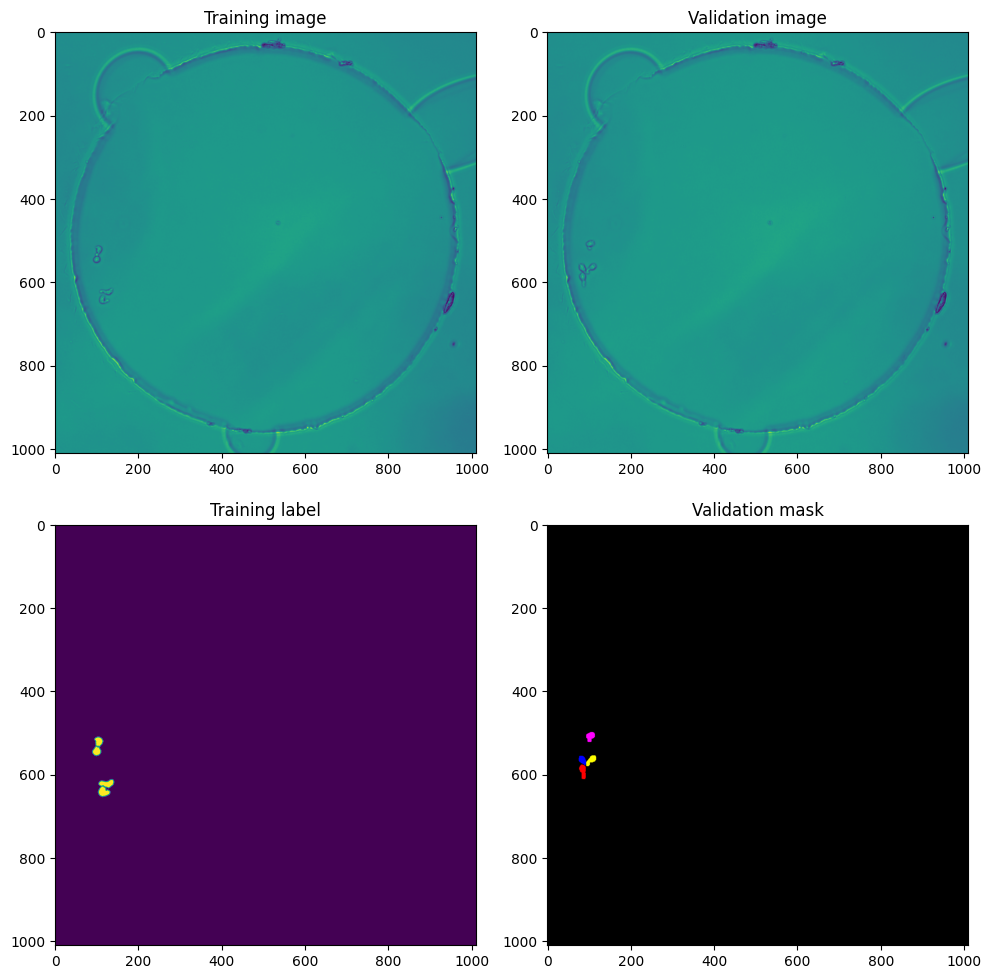

In [1]:
'''
Author:
Tianqi Guo 
Yin Wang
EISL-A @ Purdue University - School of Electrical and Computer Engineering
Do not use for commercial purposes. All rights reserved.
Contact:
guo246@purdue.edu
'''

import os
import glob
import random
import shutil

import imageio
import numpy as np
from scipy import ndimage
import skimage.color as clr
import matplotlib.pyplot as plt

def seg_to_lbl(seg, itr_dilation, itr_erosion):
    s1, s2 = seg.shape
    cell_set = np.delete(np.unique(seg), 0) 
    background = (seg == 0)
    lbl = np.zeros_like(seg, dtype=np.uint8)
    
    for cell in cell_set:    
        mask_original = (seg == cell)
        mask_dilated = ndimage.binary_dilation(mask_original, iterations=itr_dilation)
        mask_dilated = np.logical_and(mask_dilated, background)
        lbl[mask_dilated] = 1
        lbl[mask_original] = 2 
        
        mask_eroded = ndimage.binary_erosion(mask_original, iterations=itr_erosion)
        mask_boundary = np.logical_and(mask_original, np.logical_not(mask_eroded))
        ys, xs = np.nonzero(mask_boundary)
        
        for y, x in zip(ys, xs):
            for dy in range(-itr_erosion, itr_erosion + 1):
                for dx in range(-itr_erosion, itr_erosion + 1):
                    yy, xx = y + dy, x + dx                
                    if 0 <= yy < s1 and 0 <= xx < s2:
                        if seg[yy, xx] > 0 and seg[yy, xx] != cell:
                            lbl[y, x] = 1
                            break
    return lbl

def process_set(case, data_set, itr_dilation, itr_erosion, set_='train'):
    ppth = f"/home/komal.kumar/Documents/Cell/datasets/celltrack/2D/{case}"
    img_list = sorted(glob.glob(os.path.join(ppth, data_set, "*.tif")))
    print(img_list)
    
    intensity_min, intensity_max = np.inf, 0
    
    for image_path in img_list:
        img = np.asarray(imageio.volread(image_path), dtype=np.double)        
        intensity_min = np.minimum(intensity_min, img.min())
        intensity_max = np.maximum(intensity_max, img.max())
    
    intensity_range = intensity_max - intensity_min
    print(intensity_min, intensity_max, intensity_range)
    
    N_valid = len(glob.glob(os.path.join(valid_IM_dir, '*.npy')))
    N_train = len(glob.glob(os.path.join(train_IM_dir, '*.npy')))
    
    images_validation_list = []
    
    for idx, image_path in enumerate(sorted(glob.glob(os.path.join(ppth, f"{data_set}_GT", "SEG", "*.tif")))):
        file_name = os.path.basename(image_path)
        f = int(''.join([c for c in file_name if c.isdigit()]))           
        images_validation_list.append(f) 
        
        img = np.asarray(imageio.volread(img_list[f]), dtype=np.single)[None, :, :]       
        img = (img - intensity_min) / intensity_range
        
        seg = np.asarray(imageio.volread(image_path), dtype=np.uint16)           
        lbl = seg_to_lbl(seg, itr_dilation, itr_erosion)
        
        data = np.array([img, lbl], dtype=object)        
        np.save(os.path.join(valid_IM_dir, '%0.4d.npy' % N_valid), data)
        imageio.imwrite(os.path.join(valid_GT_dir, 'man_seg%0.3d.tif' % N_valid), seg)
        imageio.imwrite(os.path.join(valid_RS_dir, 'mask%0.3d.tif' % N_valid), seg)
        N_valid += 1
        
    for idx, image_path in enumerate(sorted(glob.glob(os.path.join(ppth, f"{data_set}_ST", "SEG", "*.tif")))):
        file_name = os.path.basename(image_path)
        f = int(''.join([c for c in file_name if c.isdigit()]))   
        if f in images_validation_list: continue
        
        img = np.asarray(imageio.volread(img_list[f]), dtype=np.single)[None, :, :]       
        img = (img - intensity_min) / intensity_range
        
        seg = np.asarray(imageio.volread(image_path), dtype=np.uint16)                          
        lbl = seg_to_lbl(seg, itr_dilation, itr_erosion)
        
        data = np.array([img, lbl], dtype=object)        
        np.save(os.path.join(train_IM_dir, '%0.4d.npy' % N_train), data)
        imageio.imwrite(os.path.join(train_GT_dir, 'man_seg%0.3d.tif' % N_train), seg)
        imageio.imwrite(os.path.join(train_RS_dir, 'mask%0.3d.tif' % N_train), seg)
        N_train += 1
        
    return
# /home/komal.kumar/Documents/Cell/datasets/celltrack/2D/BF-C2DL-HSC
case = 'BF-C2DL-HSC' 
itr_dilation = 2
itr_erosion = 2

out_dir = os.path.join('/home/komal.kumar/Documents/Cell/datasets/pre/GT+ST', case)
if os.path.exists(out_dir):  
    shutil.rmtree(out_dir)
    
train_IM_dir = os.path.join(out_dir, '01')
train_GT_dir = os.path.join(out_dir, '01_GT', 'SEG')
train_RS_dir = os.path.join(out_dir, '01_RES')

valid_IM_dir = os.path.join(out_dir, '02')
valid_GT_dir = os.path.join(out_dir, '02_GT', 'SEG')
valid_RS_dir = os.path.join(out_dir, '02_RES')

os.makedirs(train_IM_dir)
os.makedirs(train_GT_dir)
os.makedirs(train_RS_dir)
os.makedirs(valid_IM_dir)
os.makedirs(valid_GT_dir)
os.makedirs(valid_RS_dir)

process_set(case, '01', itr_dilation, itr_erosion)
process_set(case, '02', itr_dilation, itr_erosion)

N_training = len(glob.glob(os.path.join(train_IM_dir, '*.npy')))

idx = random.randint(0, N_training-1)
img_training, lbl_training = np.load(os.path.join(train_IM_dir, '%0.4d.npy' % idx), allow_pickle=True)

print('Training set:')
print('# of training pairs:', N_training, 'range:', img_training.min(), img_training.max())
print('# of SEGs:', len(glob.glob(os.path.join(train_GT_dir, '*.tif'))), len(glob.glob(os.path.join(train_RS_dir, '*.tif'))))
print('eg # %d' % idx)

N_validation = len(glob.glob(os.path.join(valid_IM_dir, '*.npy')))
idx = random.randint(0, N_validation-1)
img_validation, lbl_validation = np.load(os.path.join(valid_IM_dir, '%0.4d.npy' % idx), allow_pickle=True)

print('Validation set:')
print('# of validation pairs:', N_validation, 'range:', img_validation.min(), img_validation.max())
print('# of SEGs:', len(glob.glob(os.path.join(valid_GT_dir, '*.tif'))), len(glob.glob(os.path.join(valid_RS_dir, '*.tif'))))
print('eg # %d' % idx)

seg = np.asarray(imageio.volread(os.path.join(valid_GT_dir, 'man_seg%0.3d.tif' % idx)), dtype=np.uint16)
seg[0, 0] = 90
seg_clr = clr.label2rgb(seg, image=None, colors=None, alpha=0.3, bg_label=0, bg_color=(0, 0, 0))

plt.figure(figsize=[10, 10])

plt.subplot(2, 2, 1)
plt.imshow(img_training[0, :, :])
plt.title('Training image')

plt.subplot(2, 2, 3)
plt.imshow(lbl_training)
plt.title('Training label')

plt.subplot(2, 2, 2)
plt.imshow(img_validation[0, :, :])
plt.title('Validation image')

plt.subplot(2, 2, 4)
plt.imshow(seg_clr)
plt.title('Validation mask')

plt.tight_layout()
plt.savefig(os.path.join(out_dir, 'sample_pairs.png'), dpi=200, transparent=False)
plt.show()


In [2]:
from src.Notebooks import XBNet


ModuleNotFoundError: No module named 'torch'

Root: /home/komal.kumar/Documents/Cell/src
Directories: ['Notebooks']
Files: ['XBNet.py', 'baseline_1.py']
----------------------------------------
Root: /home/komal.kumar/Documents/Cell/src/Notebooks
Directories: []
Files: ['__init__.py', 'EDA_one.ipynb']
----------------------------------------
